In [99]:
from tc_python import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool
import os
from itertools import product

print(f'cpu_count: {os.cpu_count()}')


In [100]:
# basename = 'tc_NiCrFe_MoTi_wt_pct'
# df_output_fname = "MultiTaskModel_NiCrFe_MoTi_TC_wt_pct.xlsx"


# # Define a configuration for elements and conditions
# element_config = {
#     "major_elements": ["Ni", "Cr", "Fe"],
#     "minor_elements": {"Mo": 0.1E-2,
#                        "Ti": 0.1E-2},
#     "default_conditions": {"Ni": 10E-2,
#                            "Cr": 10E-2,
#                            "Mo": 0.1E-2,
#                            "Ti": 0.1E-2}
# }

basename = 'tc_NiCrFeMo_Ti_wt_pct'
df_output_fname = "MultiTaskModel_NiCrFeMo_Ti_TC_wt_pct.xlsx"


# Define a configuration for elements and conditions
element_config = {
    "major_elements": ["Ni", "Cr", "Mo", "Fe"],
    "minor_elements": {
        "Ti": 0.1E-2},
    "default_conditions": {"Ni": 10E-2,
                           "Cr": 10E-2,
                           "Mo": 10E-2,
                           "Ti": 0.1E-2}
}


current_directory = os.getcwd()
cache_fname = basename + '.ipynb' + "_cache"
output_fname = os.path.splitext(basename)[0]

print("Cache Filename: ", cache_fname)
print("Output Filename: ", output_fname)
print("Current Dir: ", current_directory)


Cache Filename:  tc_NiCrFeMo_Ti_wt_pct.ipynb_cache
Output Filename:  tc_NiCrFeMo_Ti_wt_pct
Current Dir:  /nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/01_Dataset_Cleaned


In [101]:
major_elements = element_config["major_elements"]
minor_elements = element_config["minor_elements"]
default_conditions = element_config["default_conditions"]

major_elements_list = major_elements
minor_elements_list = list(minor_elements.keys())
print(major_elements_list[:-1])
print(minor_elements_list)

default_conditions_keys_list = list(default_conditions.keys())
print(default_conditions_keys_list)

default_conditions_values_list = list(default_conditions.values())
print(default_conditions_values_list)

['Ni', 'Cr', 'Mo']
['Ti']
['Ni', 'Cr', 'Mo', 'Ti']
[0.1, 0.1, 0.1, 0.001]


In [102]:
k = 20  # Example value for 'k'
tk = 300  # Example value for 'tk'

# Elements over which you want to loop
loop_elements = major_elements[:-1]
print("loop_elements: ", loop_elements)

# Create loop ranges
loop_ranges = [np.linspace(0.1E-2, 0.95, k) for _ in loop_elements]

list_of_conditions = []

# Iterate over the product of loop ranges
for combination in product(*loop_ranges):
    total_weight = sum(combination) + \
        sum(minor_elements.values())

    if total_weight <= 1:
        condition = []

        # Adding the looped elements' weights to the condition
        for i, element in enumerate(loop_elements):
            condition.append(("W({})".format(element), combination[i]))

        # Adding minor elements' weights to the condition
        for element, weight in minor_elements.items():
            condition.append(("W({})".format(element), weight))

        # # Adding other conditions
        # condition.append(("T", tk))

        list_of_conditions.append(tuple(condition))

print(len(list_of_conditions))
print(list_of_conditions[100])

loop_elements:  ['Ni', 'Cr', 'Mo']
1540
(('W(Ni)', 0.001), ('W(Cr)', 0.25073684210526315), ('W(Mo)', 0.5004736842105263), ('W(Ti)', 0.001))


### tc_calculation_FullEquil


In [103]:
def tc_calculation_FullEquil(tk, element_config=element_config):

    major_elements = element_config["major_elements"]
    minor_elements = element_config["minor_elements"]
    default_conditions = element_config["default_conditions"]

    default_conditions_keys_list = list(default_conditions.keys())
    default_conditions_values_list = list(default_conditions.values())

    # Setup thermodynamic calculation
    with TCPython() as start:
        calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5)
            .select_database_and_elements("tchea4", major_elements + list(minor_elements.keys()))
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition(f'W({default_conditions_keys_list[0]})', default_conditions_values_list[0])
            .set_condition(f'W({default_conditions_keys_list[1]})', default_conditions_values_list[1])
            .set_condition(f'W({default_conditions_keys_list[2]})', default_conditions_values_list[2])
            .set_condition(f'W({default_conditions_keys_list[3]})', default_conditions_values_list[3])
            .set_condition("T", 1000+273.15)
            .disable_global_minimization()
        )

        # ----- Generate condition combinations for equilibrium calculations -----
        k = 20

        # Elements over which you want to loop
        loop_elements = major_elements[:-1]
        print("loop_elements: ", loop_elements)

        # Create loop ranges
        loop_ranges = [np.linspace(0.1E-2, 0.95, k) for _ in loop_elements]

        list_of_conditions = []

        # Iterate over the product of loop ranges
        for combination in product(*loop_ranges):
            total_weight = sum(combination) + \
                sum(minor_elements.values())

            if total_weight <= 1:
                condition = []

                # Adding the looped elements' weights to the condition
                for i, element in enumerate(loop_elements):
                    condition.append(("W({})".format(element), combination[i]))

                # Adding minor elements' weights to the condition
                for element, weight in minor_elements.items():
                    condition.append(("W({})".format(element), weight))

                # Adding other conditions
                condition.append(("T", tk))

                list_of_conditions.append(tuple(condition))
        # ------------------------------------------------------------------------

        calculation.set_conditions_for_equilibria(list_of_conditions)

        results = calculation.calculate(
            ["np(FCC_L12)", "np(FCC_L12#1)", "np(FCC_L12#2)"], 100)

        return (
            list_of_conditions,
            results.get_values_of('np(FCC_L12)'),
            results.get_values_of('np(FCC_L12#1)'),
            results.get_values_of('np(FCC_L12#2)')
        )


### tc_calculation_Gmin


In [104]:
def tc_calculation_Gmin(Gmin_phase, element_config=element_config):

    major_elements = element_config["major_elements"]
    minor_elements = element_config["minor_elements"]
    default_conditions = element_config["default_conditions"]

    default_conditions_keys_list = list(default_conditions.keys())
    default_conditions_values_list = list(default_conditions.values())

    # Setup thermodynamic calculation
    with TCPython() as start:
        calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5)
            .select_database_and_elements("tchea4", major_elements + list(minor_elements.keys()))
            .deselect_phase("*")
            .select_phase(Gmin_phase)
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition(f'W({default_conditions_keys_list[0]})', default_conditions_values_list[0])
            .set_condition(f'W({default_conditions_keys_list[1]})', default_conditions_values_list[1])
            .set_condition(f'W({default_conditions_keys_list[2]})', default_conditions_values_list[2])
            .set_condition(f'W({default_conditions_keys_list[3]})', default_conditions_values_list[3])
            .set_condition("T", 200+273.15)
            .disable_global_minimization()
        )

        # ----- Generate condition combinations for equilibrium calculations -----
        k = 20

        # Elements over which you want to loop
        loop_elements = major_elements[:-1]
        print("loop_elements: ", loop_elements)

        # Create loop ranges
        loop_ranges = [np.linspace(0.1E-2, 0.95, k) for _ in loop_elements]

        list_of_conditions = []

        # Iterate over the product of loop ranges
        for combination in product(*loop_ranges):
            total_weight = sum(combination) + \
                sum(minor_elements.values())

            if total_weight <= 1:
                condition = []

                # Adding the looped elements' weights to the condition
                for i, element in enumerate(loop_elements):
                    condition.append(("W({})".format(element), combination[i]))

                # Adding minor elements' weights to the condition
                for element, weight in minor_elements.items():
                    condition.append(("W({})".format(element), weight))

                # # Adding other conditions
                # condition.append(("T", tk))

                list_of_conditions.append(tuple(condition))
        # ------------------------------------------------------------------------
        print(list_of_conditions[0])

        calculation.set_conditions_for_equilibria(list_of_conditions)

        results = calculation.calculate(
            [f"gm({Gmin_phase})"], 100)

        return (
            list_of_conditions,
            results.get_values_of(f"gm({Gmin_phase})")
        )


### Parallelising TC calculation


In [105]:
# Parallelize the computation over different temperature values or phases
tk_values = np.arange(900+273.15, 1300+273.15, 50)
print("Parallelised processes for FullEquil:", len(tk_values))

Gmin_phase_list = ['BCC_B2', 'FCC_L12', 'HEUSLER_L21', 'SIGMA',
                   'LIQUID', 'NI3TA_D0A', 'MU_PHASE', 'C14_LAVES', 'C15_LAVES', 'CHI_A12']
print("Parallelised processes for Gmin:", len(Gmin_phase_list))

# Preparing tuples for multiple arguments
FullEquil_args = [(tk, element_config) for tk in tk_values]
Gmin_args = [(Gmin_phase, element_config) for Gmin_phase in Gmin_phase_list]
# print(Gmin_args[0])

# Using multiprocessing pool to distribute tasks
with Pool() as pool:
    FullEquil_results = pool.starmap(tc_calculation_FullEquil, FullEquil_args)
    Gmin_results = pool.starmap(tc_calculation_Gmin, Gmin_args)

Parallelised processes for FullEquil: 8
Parallelised processes for Gmin: 10
20:38:22,553 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:38:22,555 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:38:22,558 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:38:22,563 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:38:22,568 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:38:22,573 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:38:22,572 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:38:22,593 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:38:24,175 [Thread-1] INFO  SystemBuilder: Found matching previous system

20:38:24,185 [Thread-1] INFO  SystemBuilder: Found matc

### Analyse FullEquil results

- FullEquil_results parallel processes data for 8 temperatures.
- Each temperature yields:
  - Conditions
  - Data sets: np_FCC_L12, np_FCC_L12_1, and np_FCC_L12_2.
- unpack these results into separate lists.
- Flattening removes nested structures, creating continuous lists.
- derive maximum values from the three np_FCC_L12 lists (to deal with TC naming conventions).
- This data is then structured into a concise DataFrame for easy analysis.


In [106]:
# Use list comprehension and unpacking to get lists
list_of_conditions, list_np_FCC_L12, list_np_FCC_L12_1, list_np_FCC_L12_2 = zip(
    *FullEquil_results)

# Flatten the lists
list_of_conditions = [
    item for sublist in list_of_conditions for item in sublist]
list_np_FCC_L12 = [item for sublist in list_np_FCC_L12 for item in sublist]
list_np_FCC_L12_1 = [item for sublist in list_np_FCC_L12_1 for item in sublist]
list_np_FCC_L12_2 = [item for sublist in list_np_FCC_L12_2 for item in sublist]

print(len(list_np_FCC_L12_2))

# Get the merged values using max function
list_np_FCC_L12_merge = [max(a, b, c) for a, b, c in zip(
    list_np_FCC_L12, list_np_FCC_L12_1, list_np_FCC_L12_2)]

# Construct the DataFrame
df_FullEquil = pd.DataFrame({
    default_conditions_keys_list[0]: [dict(conditions)[f'W({default_conditions_keys_list[0]})']*100 for conditions in list_of_conditions],
    default_conditions_keys_list[1]: [dict(conditions)[f'W({default_conditions_keys_list[1]})']*100 for conditions in list_of_conditions],
    default_conditions_keys_list[2]: [dict(conditions)[f'W({default_conditions_keys_list[2]})']*100 for conditions in list_of_conditions],
    default_conditions_keys_list[3]: [dict(conditions)[f'W({default_conditions_keys_list[3]})']*100 for conditions in list_of_conditions],
    'T': [dict(conditions)['T'] for conditions in list_of_conditions],
    'np(FCC_L12)': list_np_FCC_L12,
    'np(FCC_L12#1)': list_np_FCC_L12_1,
    'np(FCC_L12#2)': list_np_FCC_L12_2,
    'np(FCC_L12)_merge': list_np_FCC_L12_merge
})

df_FullEquil.to_excel(os.path.join(
    current_directory, "tc_df_FullEquil_check.xlsx"), index=False)
display(df_FullEquil.head(3))
print(df_FullEquil.shape)


12320


,Ni,Cr,Mo,Ti,T,np(FCC_L12),np(FCC_L12#1),np(FCC_L12#2),np(FCC_L12)_merge
0,0.1,0.1,0.100000,0.1,1173.15,0.0,0.0,0.0,0.0
1,0.1,0.1,5.094737,0.1,1173.15,0.0,0.0,0.0,0.0
2,0.1,0.1,10.089474,0.1,1173.15,0.0,0.0,0.0,0.0


(12320, 9)


### Filter the compo from FullEquil results

- Data representing FCC possibilities is processed.
- Groups by 'Ni', 'Cr', 'Mo', and 'Ti' are made (for same compo comparing different temperatures), and those with any 'np(FCC_L12)\_merge' value > 0.99 are filtered.
- Unique combinations of 'Ni', 'Cr', 'Mo', and 'Ti' are extracted as result_FCC_y.


,Ni,Cr,Mo,Ti,Fe
0,0.1,0.100000,0.1,0.1,99.600000
1,0.1,5.094737,0.1,0.1,94.605263
2,0.1,10.089474,0.1,0.1,89.610526


(407, 5)


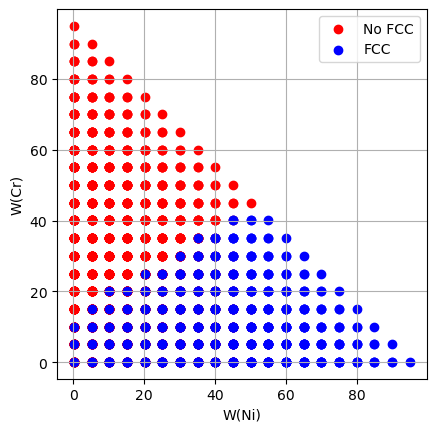

In [113]:
def filter_and_process(dataframe, func, columns=default_conditions_keys_list):
    """Filter and process the dataframe."""
    filtered = dataframe.groupby(columns).filter(func)
    processed = filtered[columns].drop_duplicates().reset_index(drop=True)
    processed['Fe'] = 100 - processed[columns].sum(axis=1)
    return processed


# Filter data for 'Y' and 'N' values
compo_FullEquil_FCC_y = filter_and_process(
    df_FullEquil, lambda x: x['np(FCC_L12)_merge'].max() > 0.99)
compo_FullEquil_FCC_n = filter_and_process(
    df_FullEquil, lambda x: x['np(FCC_L12)_merge'].max() < 0.99)

# Display and plot
display(compo_FullEquil_FCC_y.head(3))
print(compo_FullEquil_FCC_y.shape)

# Scatter plot
plt.scatter(compo_FullEquil_FCC_n['Ni'], compo_FullEquil_FCC_n['Cr'],
            marker='o', color='red', label='No FCC')
plt.scatter(compo_FullEquil_FCC_y['Ni'], compo_FullEquil_FCC_y['Cr'],
            marker='o', color='blue', label='FCC')
plt.xlabel('W(Ni)')
plt.ylabel('W(Cr)')
plt.grid(True)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.axis('square')
plt.legend()
plt.show()

### Analyse Gmin results

- Gmin_results parallel processes data for 11 phases.
- Each phase yields:
  - Conditions
  - Data sets: gm("the phase").
- unpack these results into separate lists.
- This data is then structured into a concise DataFrame for easy analysis.
- Rows where the 'Gm_FCC_L12' value is minimal are filtered into df_Gmin_FCC.


In [114]:
# Using dictionary comprehension to extract lists of Gm values
Gm_values = {phase: Gmin_results[i][1]
             for i, phase in enumerate(Gmin_phase_list)}

# Only print first few items to check
print(len(Gmin_results[0][0]))
print(Gmin_results[0][0][0])

print(len(Gm_values['FCC_L12']))
print(Gm_values['FCC_L12'][0])

# Constructing the DataFrame
df_Gmin = pd.DataFrame({
    default_conditions_keys_list[0]: [dict(conditions)[f'W({default_conditions_keys_list[0]})']*100 for conditions in Gmin_results[0][0]],
    default_conditions_keys_list[1]: [dict(conditions)[f'W({default_conditions_keys_list[1]})']*100 for conditions in Gmin_results[0][0]],
    default_conditions_keys_list[2]: [dict(conditions)[f'W({default_conditions_keys_list[2]})']*100 for conditions in Gmin_results[0][0]],
    default_conditions_keys_list[3]: [dict(conditions)[f'W({default_conditions_keys_list[3]})']*100 for conditions in Gmin_results[0][0]],
    **{f'Gm_{phase}': Gm_values[phase] for phase in Gmin_phase_list}
})

df_Gmin.to_excel(os.path.join(current_directory,
                 "tc_df_Gmin_check.xlsx"), index=False)
display(df_Gmin.head(3))


1540
(('W(Ni)', 0.001), ('W(Cr)', 0.001), ('W(Mo)', 0.001), ('W(Ti)', 0.001))
1540
-10253.82369623779


,Ni,Cr,Mo,Ti,Gm_BCC_B2,Gm_FCC_L12,Gm_HEUSLER_L21,Gm_SIGMA,Gm_LIQUID,Gm_NI3TA_D0A,Gm_MU_PHASE,Gm_C14_LAVES,Gm_C15_LAVES,Gm_CHI_A12
0,0.1,0.1,0.100000,0.1,-14154.859082,-10253.823696,NaN,-839.401022,-663.895399,-4570.841487,20316.490322,-4609.182350,-4599.662929,NaN
1,0.1,0.1,5.094737,0.1,-13829.809599,-9888.076262,NaN,-3114.088319,-961.984545,-5666.227685,16632.965619,-4641.036391,-4483.405512,NaN
2,0.1,0.1,10.089474,0.1,-13343.456434,-9360.904415,NaN,-5370.010725,-1056.533449,-6631.564570,12956.159515,-4789.543804,-4476.195924,NaN


In [115]:
# Filter rows where 'Gm_FCC_L12' has the minimum value among the columns to compare
columns_to_compare = [f'Gm_{phase}' for phase in Gmin_phase_list]
df_Gmin_FCC = df_Gmin[df_Gmin['Gm_FCC_L12'] ==
                      df_Gmin[columns_to_compare].min(axis=1)]

# Display and save
display(df_Gmin_FCC.head(3))
print(df_Gmin_FCC.shape)
# df_Gmin_FCC.to_excel(os.path.join(current_directory, "df_Gmin_FCC.xlsx"), index=False)


,Ni,Cr,Mo,Ti,Gm_BCC_B2,Gm_FCC_L12,Gm_HEUSLER_L21,Gm_SIGMA,Gm_LIQUID,Gm_NI3TA_D0A,Gm_MU_PHASE,Gm_C14_LAVES,Gm_C15_LAVES,Gm_CHI_A12
209,0.100000,95.0,0.100000,0.1,-15751.152223,-32546.289471,NaN,-4768.707128,4996.455582,NaN,9140.908900,-7832.574273,-7850.659606,-4481.1279
210,5.094737,0.1,0.100000,0.1,-14588.450755,-47170.582635,NaN,-3584.446527,-1838.747150,-6256.300417,19284.806143,-5609.165290,-5587.811867,NaN
211,5.094737,0.1,5.094737,0.1,-14268.055005,-49264.931881,NaN,-4776.259980,-2111.230903,-7357.841664,15649.263023,-5694.325098,-5534.207405,NaN


(342, 14)


### Filter the compo from Gmin results


,Ni,Cr,Mo,Ti,Fe
0,0.100000,95.0,0.100000,0.1,4.700000
1,5.094737,0.1,0.100000,0.1,94.605263
2,5.094737,0.1,5.094737,0.1,89.610526


(342, 5)


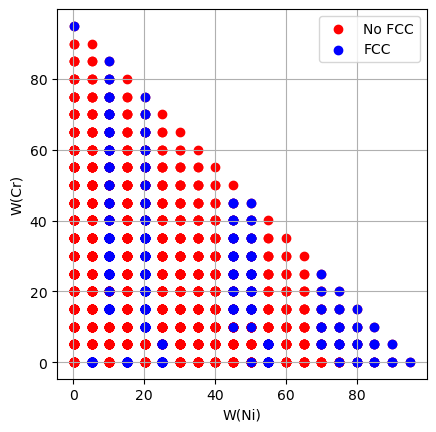

In [116]:
# Extract unique combinations of 'Ni', 'Cr', 'Mo', and 'Ti' from df_Gmin_FCC
compo_Gmin_FCC_y = df_Gmin_FCC[default_conditions_keys_list].drop_duplicates(
).reset_index(drop=True)

compo_Gmin_FCC_all = df_Gmin[default_conditions_keys_list].drop_duplicates(
).reset_index(drop=True)

# Compute 'Fe' values for each row
compo_Gmin_FCC_y['Fe'] = 100 - \
    (compo_Gmin_FCC_y[default_conditions_keys_list].sum(axis=1))

compo_Gmin_FCC_all['Fe'] = 100 - \
    (compo_Gmin_FCC_all[default_conditions_keys_list].sum(axis=1))

# Get the rows which are in compo_Gmin_FCC_all but not in compo_Gmin_FCC_y
compo_Gmin_FCC_n = pd.concat(
    [compo_Gmin_FCC_all, compo_Gmin_FCC_y, compo_Gmin_FCC_y]).drop_duplicates(keep=False)

# Display the first few rows and the shape of the dataframe
display(compo_Gmin_FCC_y.head(3))
print(compo_Gmin_FCC_y.shape)

# Scatter plot
plt.scatter(compo_Gmin_FCC_all['Ni'], compo_Gmin_FCC_all['Cr'],
            marker='o', color='red', label='No FCC')
plt.scatter(compo_Gmin_FCC_y['Ni'], compo_Gmin_FCC_y['Cr'],
            marker='o', color='blue', label='FCC')

plt.xlabel('W(Ni)')
plt.ylabel('W(Cr)')
plt.grid(True)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.axis('square')
plt.legend()
plt.show()


### Output shared compo space


(126, 5)


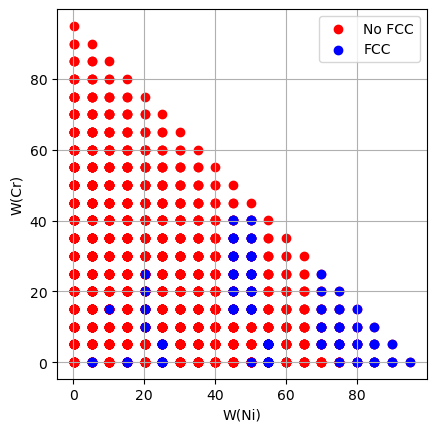

In [117]:
compo_FullEquil_Gmin_FCC_y = pd.merge(
    compo_Gmin_FCC_y, compo_FullEquil_FCC_y, how='inner')
print(compo_FullEquil_Gmin_FCC_y.shape)

# Scatter plot
plt.scatter(compo_Gmin_FCC_all['Ni'], compo_Gmin_FCC_all['Cr'],
            marker='o', color='red', label='No FCC')
plt.scatter(compo_FullEquil_Gmin_FCC_y['Ni'], compo_FullEquil_Gmin_FCC_y['Cr'],
            marker='o', color='blue', label='FCC')

plt.xlabel('W(Ni)')
plt.ylabel('W(Cr)')
plt.grid(True)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.axis('square')
plt.legend()
plt.show()

compo_FullEquil_Gmin_FCC_y.to_excel(
    os.path.join(current_directory, df_output_fname), index=False)
